<a href="https://colab.research.google.com/github/taegukang35/rne_pj/blob/main/hallway_unet_test_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

In [32]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d taegukang0305/semantic-hallway-dataset

semantic-hallway-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [33]:
!unzip /content/semantic-hallway-dataset.zip

Archive:  /content/semantic-hallway-dataset.zip
replace school_hallway/annotation_train/1000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [34]:
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 256 # for faster computing on kaggle
IMG_HEIGHT = 256 # for faster computing on kaggle
IMG_CHANNELS = 3
seed = 42

In [35]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

#https://www.kaggle.com/taegukang0305/unet-imagedatagenerator-lb-0-336/edit

In [36]:
SIZE_X = 256 #Resize images (height  = X, width = Y)
SIZE_Y = 256
 
#Capture training image info as a list
train_img = []
 
for directory_path in glob.glob("/content/school_hallway/images_train"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_img.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_img)
 
#Capture mask/label info as a list
train_mask = [] 
for directory_path in glob.glob("/content/school_hallway/annotation_train"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_mask.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_mask)

In [ ]:
X = train_images
Y = train_mask
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
 
x_train = np.asarray(x_train).astype('float32')
x_val = np.asarray(x_val).astype('float32')
y_train = np.asarray(y_train)[:,:,:,0].astype('float32')
y_train =  np.expand_dims(y_train,axis=3)
y_val = np.asarray(y_val)[:,:,:,0].astype('float32')
y_val = np.expand_dims(y_val,axis=3)

In [37]:
x_train.shape

(392, 256, 256, 3)

In [82]:
from keras.preprocessing import image

# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(x_train[:int(x_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(y_train[:int(y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(x_train[:int(x_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(y_train[:int(y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(x_train[int(x_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(y_train[int(y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(x_train[int(x_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(y_train[int(y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

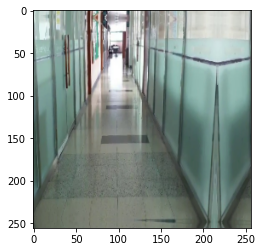

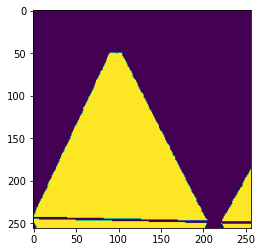

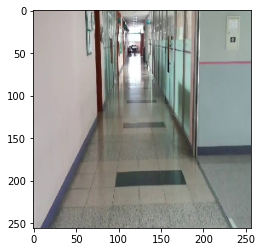

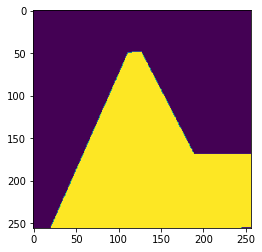

In [83]:
# Checking if the images fit

from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(x.next()[0].astype(np.uint8))
plt.show()
plt.imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
plt.imshow(x_val.next()[0].astype(np.uint8))
plt.show()
plt.imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [84]:
#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [85]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [86]:
# Define IoU metric
"""def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred = tf.cast(y_pred > t, dtype=tf.int32)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)"""
def mean_IoU(y_true, y_pred):
	s = K.shape(y_true)

	# reshape such that w and h dim are multiplied together
	y_true_reshaped = K.reshape( y_true, tf.stack( [-1, s[1]*s[2], s[-1]] ) )
	y_pred_reshaped = K.reshape( y_pred, tf.stack( [-1, s[1]*s[2], s[-1]] ) )

	# correctly classified
	clf_pred = K.one_hot( K.argmax(y_pred_reshaped), nb_classes = s[-1])
	equal_entries = K.cast(K.equal(clf_pred,y_true_reshaped), dtype='float32') * y_true_reshaped

	intersection = K.sum(equal_entries, axis=1)
	union_per_class = K.sum(y_true_reshaped,axis=1) + K.sum(y_pred_reshaped,axis=1)

	iou = intersection / (union_per_class - intersection)
	iou_mask = tf.is_finite(iou)
	iou_masked = tf.boolean_mask(iou,iou_mask)

	return K.mean( iou_masked ) 

In [87]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 256, 256, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_152 (Conv2D)             (None, 256, 256, 16) 448         lambda_8[0][0]                   
__________________________________________________________________________________________________
dropout_72 (Dropout)            (None, 256, 256, 16) 0           conv2d_152[0][0]                 
____________________________________________________________________________________________

In [90]:
history = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=100, callbacks=[earlystopper, checkpointer])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
250/250 [==============================] - 78s 293ms/step - loss: 0.5258 - acc: 0.7224 - val_loss: 1.1229 - val_acc: 0.5907

Epoch 00001: val_loss did not improve from 0.26872
Epoch 2/100
250/250 [==============================] - 71s 285ms/step - loss: 0.1739 - acc: 0.9314 - val_loss: 1.7010 - val_acc: 0.6117

Epoch 00002: val_loss did not improve from 0.26872
Epoch 3/100
250/250 [==============================] - 71s 282ms/step - loss: 0.1614 - acc: 0.9423 - val_loss: 1.0349 - val_acc: 0.7070

Epoch 00003: val_loss did not improve from 0.26872
Epoch 4/100
250/250 [==============================] - 70s 281ms/step - loss: 0.1099 - acc: 0.9619 - val_loss: 1.5700 - val_acc: 0.6946

Epoch 00004: val_loss did not improve from 0.26872
Epoch 5/100
250/250 [==============================] - 70s 280ms/step - loss: 0.1023 - acc: 0.9663 - val_loss: 0.4807 - val_acc: 0.8495

Epoch 00005: val_loss did not improve from 0.26872
Epoch 6/100
250/250 [==============================] - 70s 2

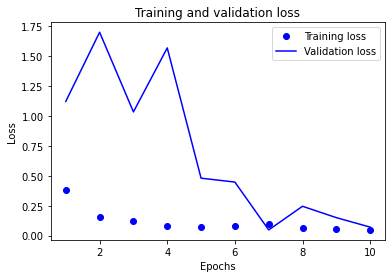

In [91]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

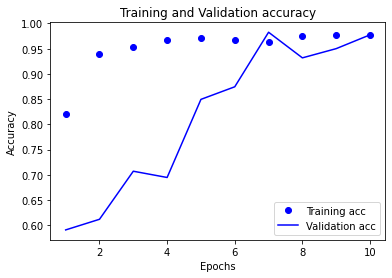

In [92]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs,acc,'bo',label ='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

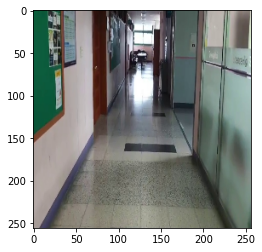

In [93]:
img_path ='/content/school_hallway/images_test/1345.png'
img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
img = cv2.resize(img, (SIZE_Y, SIZE_X))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)

In [94]:
img = np.asarray(img).astype('float32')
img = np.expand_dims(img,axis=0)
mask = model.predict(img)

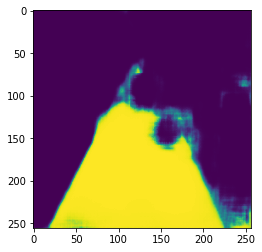

In [95]:
plt.imshow(mask[0][:,:,0])

In [96]:
def make_mask(img_path):
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
  img = cv2.resize(img, (SIZE_Y, SIZE_X))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  plt.imshow(img)
  plt.show()
  img = np.asarray(img).astype('float32')
  img = np.expand_dims(img,axis=0)
  mask = model.predict(img)
  plt.imshow(mask[0][:,:,0])
  plt.show()

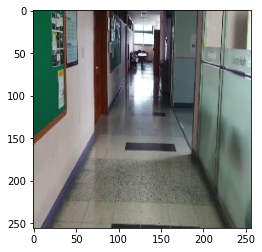

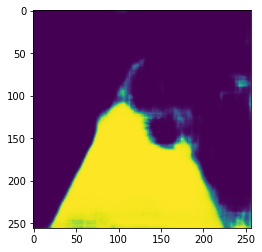

In [97]:
make_mask('/content/school_hallway/images_test/1341.png')

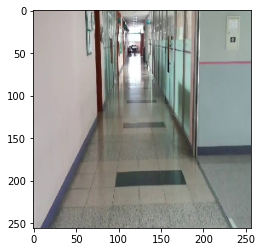

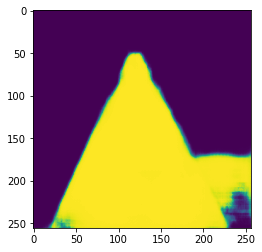

In [98]:
make_mask('/content/school_hallway/images_train/1012.png')

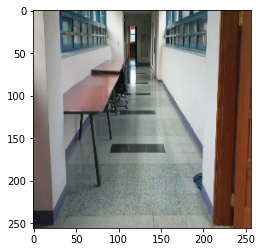

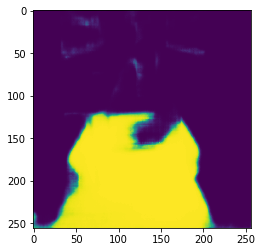

In [99]:
make_mask('/content/school_hallway/images_test/9.png')

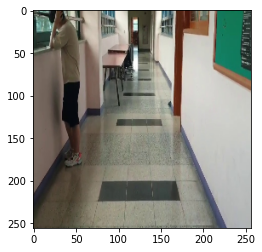

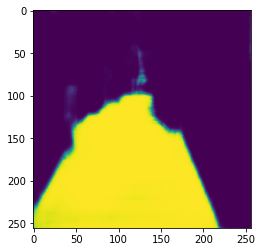

In [100]:
make_mask('/content/school_hallway/images_test/26.png')

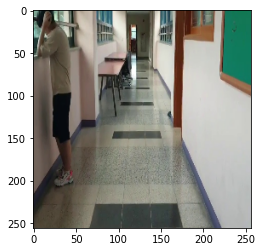

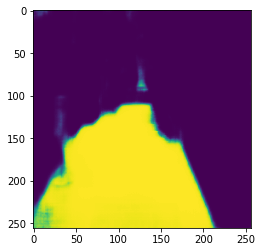

In [101]:
make_mask('/content/school_hallway/images_test/95.png')

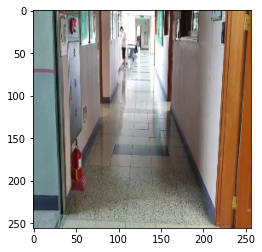

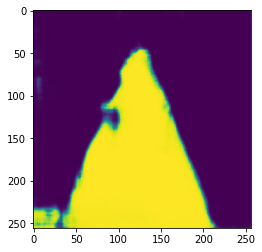

In [102]:
make_mask('/content/school_hallway/images_test/0.png')

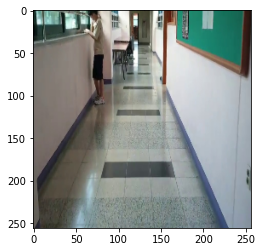

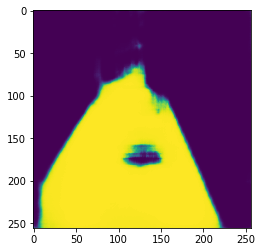

In [103]:
make_mask('/content/school_hallway/images_test/25.png')

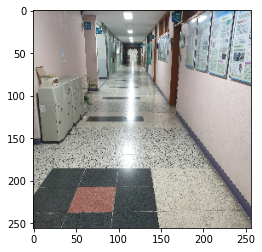

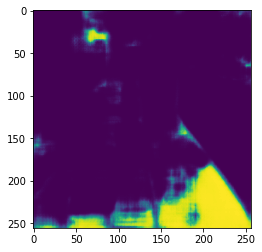

In [104]:
make_mask('/content/drive/MyDrive/myfile/20210705_232541.jpg')

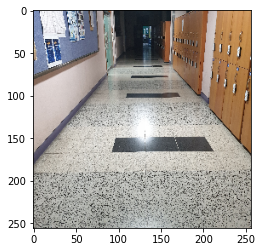

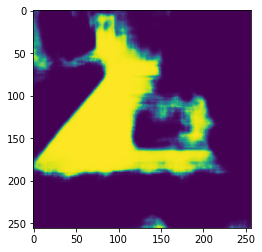

In [105]:
make_mask('/content/drive/MyDrive/myfile/20210705_232535.jpg')

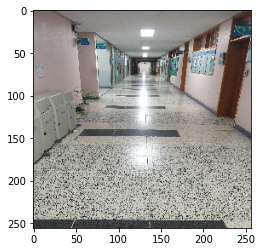

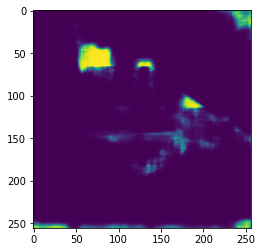

In [106]:
make_mask('/content/drive/MyDrive/myfile/20210705_232504.jpg')

In [107]:
model.save('/content/drive/MyDrive/myfile/hallway_unet_test.h5')

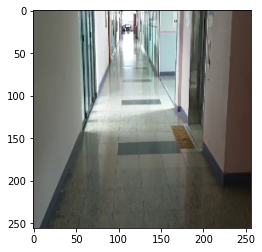

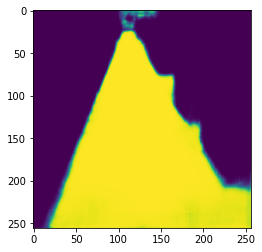

In [137]:
make_mask('/content/school_hallway/images_test/920.png')